## Initial setup

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [2]:
cd lag-llama

D:\DataScienceWithMarco\book2\code\FoundationModelsForTimeSeriesForecasting\CH04\lag-llama


D:\Anaconda\envs\lagllama-env\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!pip install -r requirements.txt

  Using cached gluonts-0.14.4-py3-none-any.whl.metadata (9.5 kB)
Using cached gluonts-0.14.4-py3-none-any.whl (1.5 MB)
  Attempting uninstall: gluonts
    Found existing installation: gluonts 0.15.0
    Uninstalling gluonts-0.15.0:
      Successfully uninstalled gluonts-0.15.0


In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir ./

\lag-llama-model\lag-llama.ckpt


## Zero-shot forecasting

In [3]:
import torch
import pandas as pd

from gluonts.dataset.pandas import PandasDataset
from gluonts.evaluation import make_evaluation_predictions

from lag_llama.gluon.estimator import LagLlamaEstimator

D:\Anaconda\envs\lagllama-env\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [4]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [7]:
from gluonts.dataset.pandas import PandasDataset

df = pd.read_csv('../../data/walmart_sales_small.csv', parse_dates=['Date'])
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [89]:
df['Weekly_Sales'] = df['Weekly_Sales'].astype('float32')

In [90]:
dataset = PandasDataset.from_long_dataframe(df, target="Weekly_Sales", item_id="Store")

backtest_dataset = dataset
prediction_length = 8 
num_samples = 100

device = torch.device("cpu") 

In [91]:
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

In [92]:
forecasts[0].samples.shape

(100, 8)

In [27]:
import numpy as np

def get_median_and_ci(data, 
                      start_date,
                      horizon,
                      freq,
                      id,
                      confidence=0.95):

    n_samples, n_timesteps = data.shape
    
    # Calculate the median for each timestep
    medians = np.median(data, axis=0)
    
    # Calculate the lower and upper percentile for the given confidence interval
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    
    # Calculate the lower and upper bounds for each timestep
    lower_bounds = np.percentile(data, lower_percentile, axis=0)
    upper_bounds = np.percentile(data, upper_percentile, axis=0)

    pred_dates = pd.date_range(start=start_date, periods=horizon, freq=freq)
    formatted_dates = pred_dates.strftime('%m-%d-%Y').tolist()
    
    # Create a DataFrame with the results
    df = pd.DataFrame({
        'Date': formatted_dates,
        'Store': id,
        'Lag-Llama': medians,
        f'Lag-Llama-lo-{int(confidence*100)}': lower_bounds,
        f'Lag-Llama-hi-{int(confidence*100)}': upper_bounds
    })
    
    return df

In [94]:
preds = [
    get_median_and_ci(
        forecasts[i].samples,
        '11-02-2012',
        8,
        'W-FRI',
        i+1
    )
    for i in range(4)
]

preds_df = pd.concat(preds, axis=0, ignore_index=True)
preds_df['Date'] = pd.to_datetime(preds_df['Date'])

preds_df

,Date,Store,Lag-Llama,Lag-Llama-lo-95,Lag-Llama-hi-95
0,2012-11-02,1,1.536882e+06,9.422835e+05,2.295642e+06
1,2012-11-09,1,1.576687e+06,9.464330e+05,2.136991e+06
2,2012-11-16,1,1.513688e+06,8.502834e+05,2.418705e+06
3,2012-11-23,1,1.576389e+06,9.806021e+05,2.198781e+06
4,2012-11-30,1,1.520313e+06,1.030522e+06,1.999708e+06
5,2012-12-07,1,1.534604e+06,1.063931e+06,1.965911e+06
6,2012-12-14,1,1.548264e+06,9.511520e+05,2.092648e+06
7,2012-12-21,1,1.568837e+06,1.100384e+06,2.116632e+06
8,2012-11-02,2,1.912487e+06,1.213276e+06,2.606179e+06
9,2012-11-09,2,1.903683e+06,8.654789e+05,2.822541e+06


In [95]:
plot_df = df.reset_index(drop=True).copy()
plot_preds_df = preds_df.copy()

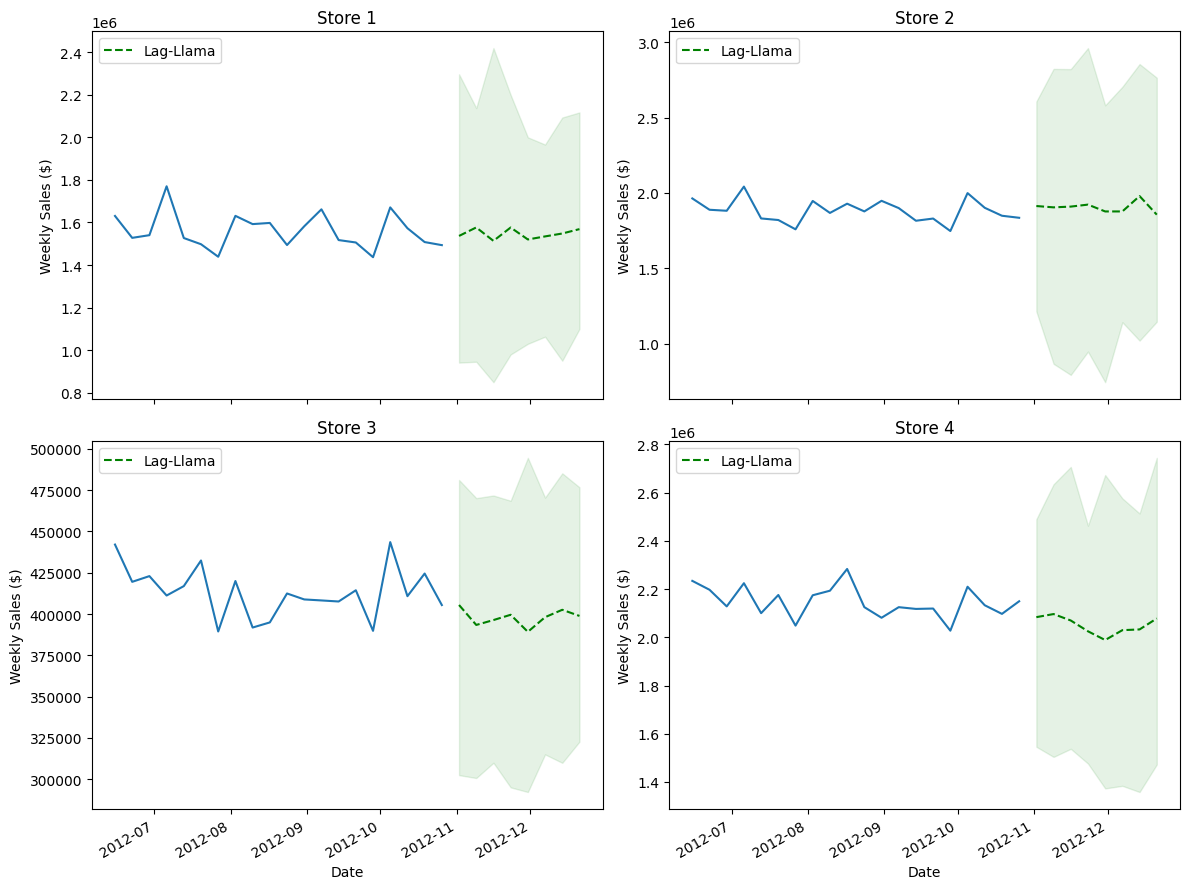

In [100]:
import matplotlib.pyplot as plt

df = df.reset_index(drop=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    df = plot_df[plot_df['Store'] == i+1].iloc[-20:]
    preds_df = plot_preds_df[plot_preds_df['Store'] == i+1]

    ax.plot(df['Date'], df['Weekly_Sales'])
    ax.plot(preds_df['Date'], preds_df['Lag-Llama'], 'g--', label='Lag-Llama')
    ax.fill_between(preds_df['Date'], preds_df['Lag-Llama-lo-95'], preds_df['Lag-Llama-hi-95'], alpha=0.1, color='green')
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('../figures/CH04_codefig01.png', dpi=300)

## Tuning the context length

In [8]:
df = df[df['Store'] == 1]

input_df = df[:-8]
test_df = df[-8:]

In [9]:
input_df.loc[:, 'Weekly_Sales'] = input_df['Weekly_Sales'].astype('float32')

In [16]:
input_ds = PandasDataset.from_long_dataframe(input_df, target="Weekly_Sales", item_id="Store")

backtest_dataset = input_ds
prediction_length = 8 
num_samples = 100

device = torch.device("cpu") 

In [25]:
forecasts_32, _ = get_lag_llama_predictions(backtest_dataset, 
                                            prediction_length, 
                                            device,
                                            context_length=32,
                                            num_samples=num_samples)

forecasts_64, _ = get_lag_llama_predictions(backtest_dataset,
                                        prediction_length,
                                        device,
                                        context_length=64,
                                        num_samples=num_samples)

forecasts_128, _ = get_lag_llama_predictions(backtest_dataset,
                                         prediction_length,
                                         device,
                                         context_length=128,
                                         num_samples=num_samples)

In [30]:
preds_32 = get_median_and_ci(forecasts_32[0].samples,
                            start_date='2012-09-07',
                            horizon=8,
                            freq='W-FRI',
                            id=1,
                            confidence=0.80)

In [32]:
preds_64 = get_median_and_ci(forecasts_64[0].samples,
                            start_date='2012-09-07',
                            horizon=8,
                            freq='W-FRI',
                            id=1,
                            confidence=0.80)

In [33]:
preds_128 = get_median_and_ci(forecasts_128[0].samples,
                            start_date='2012-09-07',
                            horizon=8,
                            freq='W-FRI',
                            id=1,
                            confidence=0.80)

In [38]:
import numpy as np
import pandas as pd

def calculate_mae_smape(pred_df, test_df, target_col, pred_col):
    
    # Extract the relevant columns
    y_true = test_df[target_col].values
    y_pred = pred_df[pred_col].values
    
    # Calculate MAE
    mae = int(np.mean(np.abs(y_true - y_pred)))
    
    # Calculate sMAPE
    denominator = np.abs(y_true) + np.abs(y_pred)
    smape = round(np.mean(2.0 * np.abs(y_true - y_pred) / denominator) * 100,2)
    
    return mae, smape

In [42]:
mae_32, smape_32 = calculate_mae_smape(preds_32, test_df, 'Weekly_Sales', 'Lag-Llama')
mae_64, smape_64 = calculate_mae_smape(preds_64, test_df, 'Weekly_Sales', 'Lag-Llama')
mae_128, smape_128 = calculate_mae_smape(preds_128, test_df, 'Weekly_Sales', 'Lag-Llama')

print("Context length: 32")
print(f"MAE: {mae_32}$, sMAPE:{smape_32}%\n")

print("Context length: 64")
print(f"MAE: {mae_64}$, sMAPE:{smape_64}%\n")

print("Context length: 128")
print(f"MAE: {mae_128}$, sMAPE:{smape_128}%\n")

Context length: 32
MAE: 81523$, sMAPE:5.24%

Context length: 64
MAE: 68654$, sMAPE:4.41%

Context length: 128
MAE: 67422$, sMAPE:4.34%



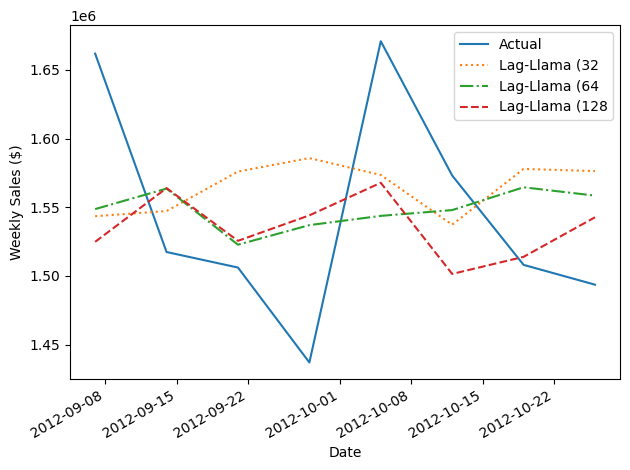

In [53]:
import matplotlib.pyplot as plt

test_df.loc[:, 'Date'] = pd.to_datetime(test_df['Date'])

fig, ax = plt.subplots()

ax.plot(test_df['Date'], test_df['Weekly_Sales'], label='Actual')
ax.plot(test_df['Date'], preds_32['Lag-Llama'], ls=':', label='Lag-Llama (32')
ax.plot(test_df['Date'], preds_64['Lag-Llama'], ls='-.', label='Lag-Llama (64')
ax.plot(test_df['Date'], preds_128['Lag-Llama'], ls='--', label='Lag-Llama (128')

ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales ($)')
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('../figures/CH04_codefig02.png', dpi=300)

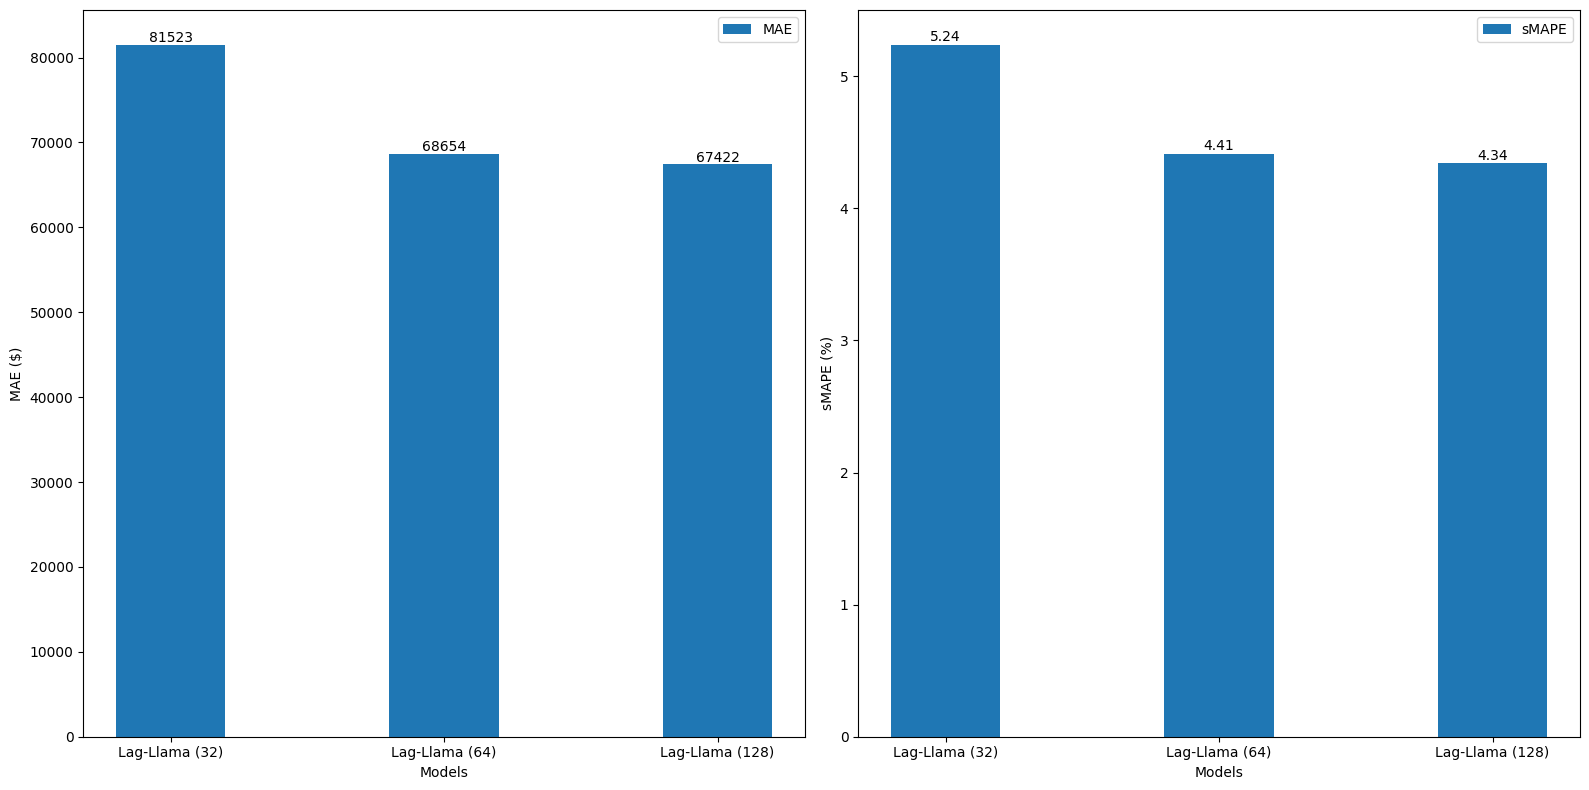

In [54]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['Lag-Llama (32)', 'Lag-Llama (64)', 'Lag-Llama (128)']
y_mae = [mae_32, mae_64, mae_128]
y_smape = [smape_32, smape_64, smape_128]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.legend()

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+300, s=str(v), ha='center')

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.legend()

for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center')

plt.tight_layout()

plt.savefig('../figures/CH04_codefig03.png', dpi=300)

## Fine-tuning Lag-Llama

In [19]:
prediction_length = 8
context_length = 128
num_samples = 50

ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        batch_size=16,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 10,}
    )

In [16]:
input_ds = PandasDataset.from_long_dataframe(input_df, target="Weekly_Sales", item_id="Store")

predictor = estimator.train(input_ds, 
                            cache_data=True, 
                            shuffle_buffer_length=1000)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.